In [1]:
#@title Data loading2

import os, requests
import numpy as np
import pandas as pd

# give google colab access to your drive
from google.colab import drive
drive.mount('/content/drive')

wd="drive/My Drive/data/"

all_fnames = ['gratings_noisy_GT1_2019_04_08_1.npy', \
          'gratings_static_GT1_2019_04_17_1.npy',\
          'minnie_GT1_2019_04_29_2.npy',\
          'gratings_drifting_GT1_2019_04_12_1.npy',\
          'gratings_local_GT1_2019_04_27_2.npy']
fname_keys = ['noisy', 'static', 'minnie', 'drifting', 'local']



Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
#@title Data loading
# load this mouse's data
dats={}
# which files do you want to load?
idx = [1,3]
# load each file and save it in a new array
for ind in idx:
  dats[fname_keys[ind]] = np.load(os.path.join(wd, all_fnames[ind]), allow_pickle=True).item()


In [4]:
#@title PCA functions
n_cmp = 20

from matplotlib import pyplot as plt
from scipy.signal import butter, filtfilt
from scipy.stats import zscore
from sklearn.decomposition import PCA 
def run_pca(dat, zs=True, n_cmp=n_cmp):
  if zs:
    Z = zscore(dat['sresp'], axis=1)
  else:
    Z = dat['sresp']
  p = PCA(n_components = n_cmp)
  p.fit_transform(Z.T)
  X = p.components_@Z
  return p, X

def plot_pca_weights(dat, istim, X, n_cmp=n_cmp):
  b,a = butter(4, [0.05], 'lowpass') #creating a low pass butterworth filter
  idx = np.argsort(dat['istim'])
  fig = plt.figure(figsize = (15,10))
  for j in np.arange(n_cmp):
      fig.add_subplot(4,5,j+1,polar = True)
      plt.plot(dat['istim'][idx],filtfilt(b,a,X[j,idx]))
      #plt.scatter(dat['istim'][idx],X[j,idx])
      plt.title('PC %d\n' %j, loc='center', pad=-85)
  plt.show()

def run_pca_and_plot(dat, zs=True, n_cmp=n_cmp):
  # PCA
  _, X = run_pca(dat, zs, n_cmp)
  # Plot
  plot_pca_weights(dat, dat['istim'], X, n_cmp)

In [ ]:
# run PCA and plot weights for static images
run_pca_and_plot(dats['static'])

In [ ]:
#@ Store (x,y) positions of each neuron
tp = np.zeros(((dat['sresp'].shape[1]),2))
for k in range(dat['sresp'].shape[1]):
    tp[k,:] = np.array([dat['stat'][k]['xpix'].mean(),dat['stat'][k]['ypix'].mean()])

In [ ]:
#@ Split the data into training (2/3) and testing (1/3)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X.T, dat['istim'])
print('Training data size = ', X_train.shape)
print('Training target size = ', y_train.shape)
print('Testing data size = ', X_test.shape)
print('Testing target size = ', y_test.shape)

Training data size =  (3448, 20)
Training target size =  (3448,)
Testing data size =  (1150, 20)
Testing target size =  (1150,)


In [ ]:
from sklearn.linear_model import LinearRegression
mod = LinearRegression()
mod.fit(X_train, y_train)

LinearRegression()

In [ ]:
def plot_model_results(output_train, y_train, output_test, y_test):
    from matplotlib import pyplot as plt
    from scipy.stats import circmean, pearsonr
    fig = plt.figure()
    #@ Training data
    idx = np.argsort(y_train.T)
    fig.add_subplot(1,2,1,polar = True)
    plt.polar(output_train[idx],np.arange(len(output_train)),'.')
    plt.polar(y_train[idx],np.arange(len(output_train)),'.',markersize = 2, alpha = 1)
    plt.title('Training\n')

    x = np.sin(output_train - circmean(output_train))
    y = np.sin(y_train - circmean(y_train))
    acc1 = pearsonr(x,y)[0]**2

    #@ Testing data
    idx = np.argsort(y_test.T)
    fig.add_subplot(1,2,2,polar = True)
    plt.polar(output_test[idx],np.arange(len(output_test)),'.')
    plt.polar(y_test[idx],np.arange(len(output_test)),'.',markersize = 2, alpha = 1)
    plt.title('Testing\n')

    x = np.sin(output_test - circmean(output_test))
    y = np.sin(y_test - circmean(y_test))
    acc2 = pearsonr(x,y)[0]**2

    print('Training r^2: ',f'{acc1:.2f}')
    print('Testing r^2: ',f'{acc2:.2f}')
    
    return None

Training r^2:  0.81
Testing r^2:  0.76


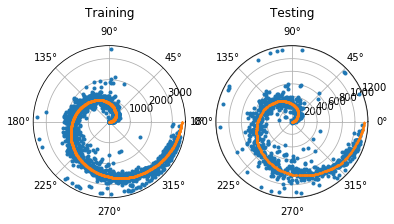

In [ ]:
from sklearn.neural_network import MLPRegressor
mod2 = MLPRegressor(solver='lbfgs',activation= 'tanh' , alpha=1e-5, hidden_layer_sizes=(20,1), random_state=1, max_iter = 1e4)
mod2.fit(X_train, y_train)
plot_model_results(mod2.predict(X_train), y_train, mod2.predict(X_test), y_test)

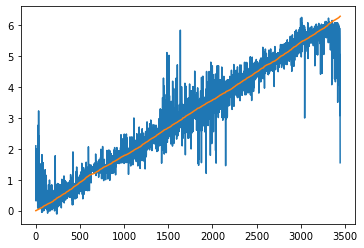

In [ ]:
plt.plot(mod2.predict(X_train)[idx])
plt.plot(y_train[idx])

In [ ]:
idx = np.argsort(y_train)
y_train_2d = np.zeros((len(y_train),2))
y_train_2d[:,0], y_train_2d[:,1] =  np.cos(y_train) ,  np.sin(y_train)

y_test_2d = np.zeros((len(y_test),2))
y_test_2d[:,0], y_test_2d[:,1] =  np.cos(y_test) ,  np.sin(y_test)

Training r^2:  0.97
Testing r^2:  0.92


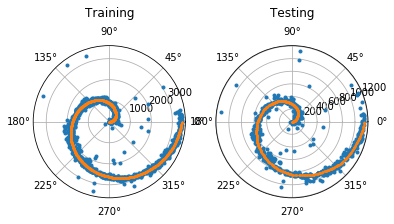

In [ ]:
from sklearn.neural_network import MLPRegressor
mod3 = MLPRegressor(solver='lbfgs',activation= 'tanh' , alpha=1e-5, hidden_layer_sizes=(20,2), random_state=1, max_iter = 1e3)
mod3.fit(X_train, y_train_2d)
o1 = mod3.predict(X_train)
o2 = mod3.predict(X_test)
plot_model_results(np.arctan2(o1[:,1], o1[:,0]), y_train, np.arctan2(o2[:,1], o2[:,0]), y_test)

(0, 76.63333333333334)

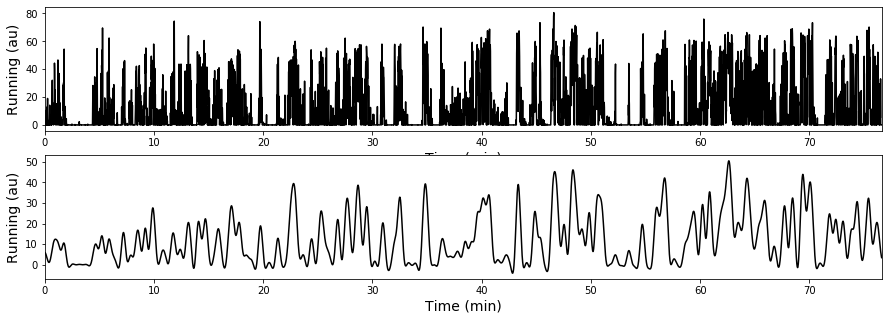

In [ ]:
fig = plt.figure(figsize = (15,5))
[b,a] = butter(4, 0.05, 'lowpass')
plt.subplot(2,1,1)
plt.plot(np.arange(len(dat['run']))/60, dat['run'], 'k')
plt.xlim([0, len(dat['run'])/60])
plt.ylabel('Running (au)', fontsize = 14)
plt.xlabel('Time (min)', fontsize = 14)
plt.subplot(2,1,2)
plt.plot(np.arange(len(dat['run']))/60, filtfilt(b,a,dat['run']), 'k')
plt.ylabel('Running (au)', fontsize = 14)
plt.xlabel('Time (min)', fontsize = 14)
plt.xlim([0, len(dat['run'])/60])

Text(0.5, 0, 'Time (min)')

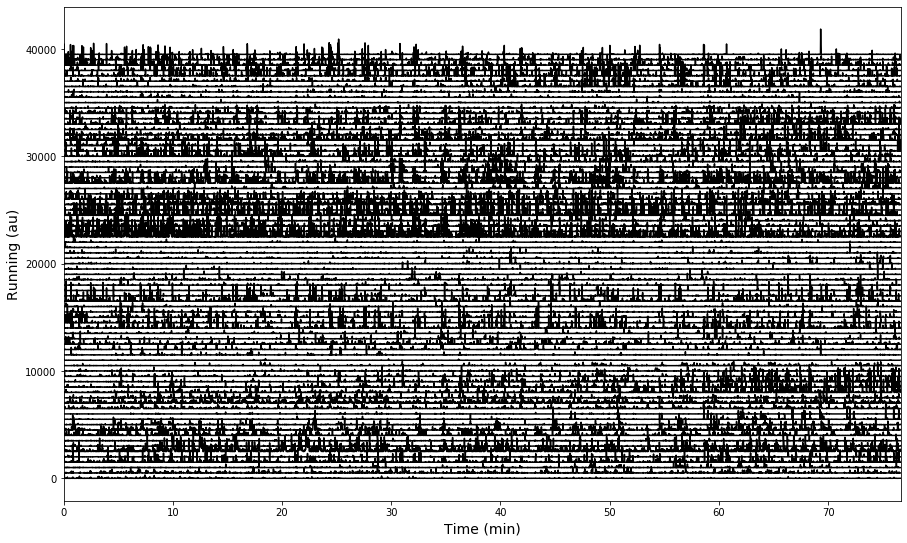

In [ ]:
fig = plt.figure(figsize = (15,20))
[b,a] = butter(4, 0.05, 'lowpass')
plt.subplot(2,1,1)
for i in np.arange(80):
    plt.plot(np.arange(len(dat['run']))/60, dat['sresp'][i] + i*5e2, 'k')
plt.xlim([0, len(dat['run'])/60])
plt.ylabel('Running (au)', fontsize = 14)
plt.xlabel('Time (min)', fontsize = 14)